In [1]:
!nvidia-smi

Sun Nov  4 19:06:00 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.54                 Driver Version: 396.54                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:0B:00.0 Off |                  N/A |
| 23%   39C    P8    18W / 250W |      2MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 00000000:41:00.0  On |                  N/A |
| 38%   64C    P0    63W / 250W |   1380MiB / 12188MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from itertools import cycle, count
from textwrap import wrap

import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import time
import json
import sys
import gym
import io

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

plt.style.use('fivethirtyeight')
np.set_printoptions(suppress=True)

%matplotlib inline

In [3]:
torch.cuda.is_available()

True

In [4]:
def make_monitored_env(env_name, monitor_mode, seed):
    mdir = tempfile.mkdtemp()
    env = gym.make(env_name)
    env = wrappers.Monitor(env, mdir, force=True, mode=monitor_mode)
    env.seed(seed)
    return env

In [5]:
def plot_results(results, log_scale=False):
    plt.figure(figsize=(15, 10))
    lines = ["-","--",":","-."]
    linecycler = cycle(lines)
    for experiment, experiment_name, env in results:
        label = '\n'.join(wrap(experiment_name.replace('_', ', '), 50))
        plt.plot(experiment, next(linecycler), label=label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if log_scale: plt.xscale('log')
    plt.ylabel('Rewards')
    plt.xlabel('Episode')
    plt.show()

In [6]:
def get_videos_html(env_videos, title, max_n_videos=3):
    videos = np.array(env_videos)
    n_videos = min(max_n_videos, len(videos))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
    videos = videos[idxs,:]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        video = io.open(video_path, 'r+b').read()
        encoded = base64.b64encode(video)

        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <video width="960" height="540" controls>
            <source src="data:video/mp4;base64,{1}" type="video/mp4" />
        </video>"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [7]:
def get_gif_html(env_videos, title, max_n_videos=3):
    videos = np.array(env_videos)
    n_videos = min(max_n_videos, len(videos))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
    videos = videos[idxs,:]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        basename = os.path.splitext(video_path)[0]
        gif_path = basename + '.gif'
        if not os.path.exists(gif_path):
            ps = subprocess.Popen(
                ('ffmpeg', 
                 '-i', video_path, 
                 '-r', '10', 
                 '-f', 'image2pipe', 
                 '-vcodec', 'ppm', 
                 '-'), 
                stdout=subprocess.PIPE)
            output = subprocess.check_output(
                ('convert', 
                 '-delay', '5', 
                 '-loop', '0', 
                 '-', gif_path), 
                stdin=ps.stdout)
            ps.wait()

        gif = io.open(gif_path, 'r+b').read()
        encoded = base64.b64encode(gif)
            
        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <img src="data:image/gif;base64,{1}" />"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [8]:
class FCQ(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim, 
                 hidden_dims=(32,32), 
                 activation_fc=F.relu):
        super(FCQ, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, 
                                     hidden_dims[0])

        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(
                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(
            hidden_dims[-1], output_dim)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x
    
    def numpy_float_to_device(self, variable):
        variable = torch.from_numpy(variable).float().to(self.device)
        return variable
    
    def load_experiences(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [9]:
class FCDuelingQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
        super(FCDuelingQ, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.output_value = nn.Linear(hidden_dims[-1], 1)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32).unsqueeze(0)      
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        v = self.output_value(x)
        a = self.output_layer(x)
        q = v.expand_as(a) + (a - a.mean(1, keepdim=True).expand_as(a))
        return q

    def numpy_float_to_device(self, variable):
        variable = torch.from_numpy(variable).float().to(self.device)
        return variable

    def load_experiences(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [10]:
class ReplayBuffer():
    def __init__(self, max_samples=100000, batch_size=32):
        self.memory = deque(maxlen=max_samples)
        self.batch_size = batch_size

    def store(self, sample):
        self.memory.append(sample)

    def sample(self, batch_size=None):
        batch_size = self.batch_size if batch_size == None else batch_size
        idxs = np.random.choice(len(self.memory), batch_size)
        samples = np.array([self.memory[idx] for idx in idxs])
        batches = [np.vstack(batch_type) for batch_type in samples.T]
        return batches
    
    def is_prioritized(self):
        return False

    def __len__(self):
        return len(self.memory)

In [11]:
class PrioritizedReplayBuffer():
    def __init__(self, max_samples=100000, batch_size=32, rank_based=True, 
                 alpha=0.7, beta0=0.5, beta_rate=0.999965, epsilon=0.001):
        self.max_samples = max_samples
        self.memory = np.empty(shape=(self.max_samples, 2), dtype=np.ndarray)
        self.batch_size = batch_size
        self.n_entries = 0
        self.next_index = 0
        self.td_error_index = 0
        self.sample_index = 1
        self.rank_based = rank_based # if not rank_based, then proportional
        self.alpha = alpha # how much prioritization to use 0 is uniform (no priority), 1 is full priority
        self.beta = beta0 # bias correction 0 is no correction 1 is full correction
        self.beta0 = beta0 # beta0 is just beta's initial value
        self.beta_rate = beta_rate
        self.epsilon = epsilon

    def update(self, idxs, td_errors):
        self.memory[idxs, self.td_error_index] = np.abs(td_errors)
        if self.rank_based:
            sorted_arg = self.memory[:self.n_entries, self.td_error_index].argsort()[::-1]
            self.memory[:self.n_entries] = self.memory[sorted_arg]

    def store(self, sample):
        priority = self.memory[:self.n_entries, self.td_error_index].max() if self.n_entries > 0 else 1.0
        self.memory[self.next_index, self.td_error_index] = priority
        self.memory[self.next_index, self.sample_index] = np.array(sample)
        self.n_entries = min(self.n_entries + 1, self.max_samples)
        self.next_index += 1
        self.next_index = self.next_index % self.max_samples

    def sample(self, batch_size=None):
        batch_size = self.batch_size if batch_size == None else batch_size
        self.beta = min(1.0, self.beta * self.beta_rate**-1)
        entries = self.memory[:self.n_entries]

        if self.rank_based:
            priorities = 1/(np.arange(self.n_entries) + 1)
        else: # proportional
            priorities = entries[:, self.td_error_index] + self.epsilon
        scaled_priorities = priorities**self.alpha        
        probs = np.array(scaled_priorities/np.sum(scaled_priorities), dtype=np.float64)

        weights = (1.0/self.n_entries * 1.0/probs)**self.beta
        normalized_weights = weights/weights.max()
        idxs = np.random.choice(self.n_entries, batch_size, replace=False, p=probs)
        samples = np.array([entries[idx] for idx in idxs])
        
        samples_stacks = [np.vstack(batch_type) for batch_type in np.vstack(samples[:, self.sample_index]).T]
        idxs_stack = np.vstack(idxs)
        weights_stack = np.vstack(normalized_weights[idxs])
        return idxs_stack, weights_stack, samples_stacks

    def is_prioritized(self):
        return True

    def __len__(self):
        return self.n_entries
    
    def __repr__(self):
        return str(self.memory[:self.n_entries])
    
    def __str__(self):
        return str(self.memory[:self.n_entries])

In [12]:
class GreedyStrategy():
    def __init__(self):
        self.exploratory_action_taken = False

    def select_action(self, model, state):
        model.eval()

        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()
            return np.argmax(q_values)

In [13]:
class EGreedyLinearStrategy():
    def __init__(self, init_epsilon=1.0, decay_rate=0.995, min_epsilon=0.01):
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.decay_rate = decay_rate
        self.min_epsilon = min_epsilon
        self.exploratory_action_taken = None

    def select_action(self, model, state):
        model.eval()

        self.exploratory_action_taken = False
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))

        self.epsilon = max(self.min_epsilon, self.decay_rate*self.epsilon)
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

In [14]:
class EGreedyDecayStrategy():
    def __init__(self, init_epsilon=1.0, decay_rate=1e-5, min_epsilon=0.1):
        self.t = 0
        self.init_epsilon = init_epsilon
        self.epsilon = init_epsilon
        self.decay_rate = decay_rate
        self.min_epsilon = min_epsilon
        self.exploratory_action_taken = None

    def select_action(self, model, state):
        model.eval()
        
        self.exploratory_action_taken = False
        self.epsilon = max(self.init_epsilon * np.exp(-self.decay_rate * self.t), 
                           self.min_epsilon)
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))

        self.t += 1
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

In [15]:
class StaircaseStrategy():
    def __init__(self, staircase):
        self.t = 0
        self.index = 0
        self.epsilon = list(staircase.keys())[self.index]
        self.staircase = staircase
        self.exploratory_action_taken = None

    def select_action(self, model, state):
        model.eval()
        
        self.exploratory_action_taken = False
        if list(self.staircase.values())[self.index] and self.t > list(self.staircase.values())[self.index]:
            self.index += 1
            self.epsilon = list(self.staircase.keys())[self.index]
            self.t = 0

        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))

        self.t += 1
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

In [16]:
class SoftMaxStrategy():
    def __init__(self, init_temp=1.0, min_temp=0.1, exploration_ratio=0.9, max_steps=20000):
        self.t = 0
        self.init_temp = init_temp
        self.exploration_ratio = exploration_ratio
        self.min_temp = min_temp
        self.max_steps = max_steps
        self.exploratory_action_taken = None

    def select_action(self, model, state):
        model.eval()
        
        self.exploratory_action_taken = False
        temp = 1 - self.t / (self.max_steps * self.exploration_ratio)
        temp = (self.init_temp - self.min_temp) * temp + self.min_temp
        temp = np.clip(temp, self.min_temp, self.init_temp)

        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()
            scaled_qs = q_values/temp
            norm_qs = scaled_qs - scaled_qs.max()            
            e = np.exp(norm_qs)
            probs = e / np.sum(e)
            assert np.isclose(probs.sum(), 1.0)

        action = np.random.choice(np.arange(len(probs)), size=1, p=probs)[0]
        self.t += 1
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

In [17]:
class DQNAgent():
    def __init__(self, buffer, model, optimizer, optimizer_lr, strategy, 
                 update_target_every_timesteps, train_every_timesteps, 
                 double_learning_enabled, tau, max_gradient, n_warmup_batch, 
                 print_every_episodes=25, save_every_episodes=500,
                 experiment_name='default'):
        
        self.buffer = buffer()
        self.model_fn = model
        self.optimizer_fn = optimizer
        self.optimizer_lr = optimizer_lr
        self.strategy = strategy()
        self.update_target_every_timesteps = update_target_every_timesteps
        self.train_every_timesteps = train_every_timesteps
        self.double_learning_enabled = double_learning_enabled
        self.tau = tau
        self.max_gradient = max_gradient
        self.n_warmup_batch = n_warmup_batch
        self.print_every_episodes = print_every_episodes
        self.save_every_episodes = save_every_episodes
        self.experiment_name = experiment_name

    def optimize_model(self, experiences):
        self.model.train()

        if self.buffer.is_prioritized():
            idxs, weights, (states, actions, rewards, next_states, is_terminals) = experiences
        else:
            states, actions, rewards, next_states, is_terminals = experiences
            weights, idxs = np.ones_like(rewards), None
        weights = self.model.numpy_float_to_device(weights)
        batch_size = len(is_terminals)
        
        if self.double_learning_enabled:
            argmax_a_q_sp = self.model(next_states).detach().max(1)[1]
        else:
            argmax_a_q_sp = self.target(next_states).detach().max(1)[1]

        q_sp = self.target(next_states).detach()
        max_a_q_sp = q_sp[np.arange(batch_size), argmax_a_q_sp].unsqueeze(1)
        target_q_s = rewards + (self.gamma * max_a_q_sp * (1 - is_terminals))
        q_sa = self.model(states).gather(1, actions)

        td_errors = q_sa - target_q_s
        loss = (weights * td_errors).pow(2).mul(0.5).mean()
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-self.max_gradient, 
                                   self.max_gradient)
        self.optimizer.step()

        if self.buffer.is_prioritized():
            priorities = np.abs(td_errors.cpu().detach().numpy())
            self.buffer.update(idxs, priorities)
        
        
    def interaction_step(self, env, state):
        action = self.strategy.select_action(self.model, state)
        new_state, reward, is_terminal, _ = env.step(action)
        experience = (state, action, reward, new_state, float(is_terminal))
        self.buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.strategy.exploratory_action_taken)
        return new_state, is_terminal

    def train(self, env, gamma, max_episodes, max_mean_reward):
        self.gamma = gamma
        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.episode_exploration = []
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        
        self.model = self.model_fn(nS, nA)
        self.model.eval()
        self.target = self.model_fn(nS, nA)
        self.target.eval()
        self.optimizer = self.optimizer_fn(self.model, self.optimizer_lr)
        
        for episode in range(1, max_episodes + 1):
            start = time.time()
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for timestep in count(start=1):
                state, is_terminal = self.interaction_step(env, state)
                
                if len(self.buffer) > self.buffer.batch_size * self.n_warmup_batch:
                    experiences = self.buffer.sample()

                    if self.buffer.is_prioritized():
                        idxs, weights, samples = experiences
                        experiences = self.model.load_experiences(samples)
                        experiences = (idxs, weights) + (experiences,)
                    else:
                        experiences = self.model.load_experiences(experiences)
                
                    if np.sum(self.episode_timestep) % self.train_every_timesteps == 0:
                        self.optimize_model(experiences)
                
                if np.sum(self.episode_timestep) % self.update_target_every_timesteps == 0:
                    for target, network in zip(self.target.parameters(), 
                                               self.model.parameters()):
                        mixed_weights = (1.0 - self.tau) * target.data + self.tau * network.data
                        target.data.copy_(mixed_weights)
                        
                if is_terminal:
                    break
            
            self.episode_seconds.append(time.time() - start)
            mean_seconds = np.mean(self.episode_seconds[-100:])
            mean_reward = np.mean(self.episode_reward[-100:])
            mean_10_reward = np.mean(self.episode_reward[-25:])
            if episode % self.print_every_episodes == 0 or mean_reward >= max_mean_reward:
                episode_exploration_ratio = self.episode_exploration[-1] / self.episode_timestep[-1]
                debug_message = 'ep {:03}, tmstps {:05}, explr rat {:.2f}, buf sze {:05}, '
                debug_message += '25/100 ep av rew {:.2f}/{:.2f}, 100 ep av sec {:.2f}'
                debug_message = debug_message.format(
                    episode, int(np.sum(self.episode_timestep)), 
                    episode_exploration_ratio, len(self.buffer), 
                    mean_10_reward, mean_reward, mean_seconds)
                print(debug_message)

            if episode % self.save_every_episodes == 0 or mean_reward >= max_mean_reward:
                directory_name =  os.path.join('checkpoints', experiment_name.replace('_', '/'))
                filename = '{}_{}_{}.ckp'.format(episode, timestep, mean_reward)
                file_path =  os.path.join(directory_name, filename)
                if not os.path.exists(directory_name):
                    os.makedirs(directory_name)
                torch.save(self.model.state_dict(), file_path)

            if mean_reward >= max_mean_reward:
                print('Training complete')
                break

        env.close()
        return self.episode_reward

    
    def evaluate(self, env, strategy, episodes=10, render=True):
        rewards = []
        for episode in range(episodes):
            state, is_terminal = env.reset(), False
            rewards.append(0)
            for t in count(start=1):
                if render: env.render()
                action = strategy.select_action(self.model, state)
                state, reward, is_terminal, _ = env.step(action)
                rewards[-1] += reward
                if is_terminal:
                    break

        env.close()
        return rewards

In [27]:
training_env_name, testing_env_name = 'CartPole-v0', 'CartPole-v0'
buffers = {
    'prioritized-proportional': lambda: PrioritizedReplayBuffer(
        max_samples=50000, batch_size=32, rank_based=False, 
        alpha=0.5, beta0=0.4, beta_rate=0.99998, epsilon=0.001),
    #'prioritized-ranked': lambda: PrioritizedReplayBuffer(
    #    max_samples=50000, batch_size=32, rank_based=True, 
    #    alpha=0.5, beta0=0.4, beta_rate=0.99998, epsilon=0.001),
    #'uniform': lambda: ReplayBuffer(
    #    max_samples=50000, batch_size=32),
}

models = {
    'dueling' : lambda nS, nA: FCDuelingQ(
        nS, nA, hidden_dims=(64,64)),
    #'vanilla': lambda nS, nA: FCQ(
    #    nS, nA, hidden_dims=(64,64)),
}

optimizers = {
    'rmsprop': lambda net, lr: optim.RMSprop(
        net.parameters(), lr=lr),
    #'adam': lambda net, lr: optim.Adam(
    #    net.parameters(), lr=lr), 
}

strategies = {
    'softmax': lambda: SoftMaxStrategy(
        init_temp=1.0, min_temp=0.3, exploration_ratio=1.0, max_steps=5000),
    #'staircase': lambda: StaircaseStrategy(
    #    staircase={1.0:1000, 0.5:3000, 0.25:5000, 0.15:5000, 0.1:None}),
    #'egreedyexponential': lambda: EGreedyLinearStrategy(
    #    init_epsilon=1.0, decay_rate=0.998, min_epsilon=0.1),
    #'egreedylinear': lambda: EGreedyLinearStrategy(
    #    init_epsilon=1.0, decay_rate=0.998, min_epsilon=0.1),
}

optimizer_lrs = [
    #0.00079,
    0.00099,
    0.00111,
]
train_every_timestepss = [
    1,
    #2,
]
enable_double_learning = [
    True,
    # False,
]
target_update_pairs = [
    {'every-timesteps': 1, 'tau': 0.05}, 
    #{'every-timesteps': 2, 'tau': 0.1}, 
    #{'every-timesteps': 4, 'tau': 0.25}, 
    #{'every-timesteps':10, 'tau':1.0},
    {'every-timesteps':20, 'tau':1.0},
]
max_gradients = [
    8,
    float('inf'),
]
n_warmup_batches = [
    #1,
    5,
]
random_seeds = [
    12,
    #34,
    56,
    #78,
    90,
]

gamma, max_episodes, max_mean_reward = 1.0, 250, 200
print_every_episodes, save_every_episodes = 25, max_episodes
n_evaluation_episodes = 10

training_results, evaluation_results = [], []
successful_experiments = []
for n_warmup_batch in n_warmup_batches:
    print('n_warmup_batch={}'.format(n_warmup_batch))
    for strategy in strategies:
        print('\tstrategy={}'.format(strategy))
        for buffer in buffers:
            print('\t' * 2 + 'buffer={}'.format(buffer))
            for double_learning_enabled in enable_double_learning:
                print('\t' * 3 + 'double_learning_enabled={}'.format(double_learning_enabled))
                for train_every_timesteps in train_every_timestepss:
                    print('\t' * 4 + 'train_every_timesteps={}'.format(train_every_timesteps))
                    for target_update_pair in target_update_pairs:
                        print('\t' * 5 + 'target_update_pair={}'.format(target_update_pair))
                        for max_gradient in max_gradients:
                            print('\t' * 6 + 'max_gradient={}'.format(max_gradient))
                            for model in models:
                                print('\t' * 7 + 'model={}'.format(model))
                                for optimizer in optimizers:
                                    print('\t' * 8 + 'optimizer={}'.format(optimizer))
                                    for optimizer_lr in optimizer_lrs:
                                        print('\t' * 9 + 'optimizer_lr={}'.format(optimizer_lr))
                                        experiment_name = ''
                                        experiment_name += '{}_{}_{}-{}_{}'
                                        experiment_name += '_target-update-pair-{}'
                                        experiment_name += '_train-every-timesteps-{}'
                                        experiment_name += '_double-learning-enabled-{}'
                                        experiment_name += '_max-gradient-{}'
                                        experiment_name += '_n-warmup-batch-{}'

                                        experiment_name = experiment_name.format(
                                            buffer, model, optimizer, optimizer_lr, 
                                            strategy, target_update_pair, 
                                            train_every_timesteps, 
                                            double_learning_enabled, 
                                            max_gradient, n_warmup_batch
                                        )

                                        print('\nStarting experiment:{}\n{}'.format('-' * 90,
                                            '\n'.join(wrap(experiment_name.replace('_', ', '), 100))))
                                        print('Termination criteria: a last 100 episode mean reward of '
                                              '{} within {} episodes\n'.format(max_mean_reward, max_episodes))
                                        
                                        training_rewards, evaluation_rewards = [], []
                                        for seed in random_seeds:
                                            print('-----> Using seed {}'.format(seed))
                                            torch.manual_seed(seed)
                                            np.random.seed(seed)

                                            agent = DQNAgent(
                                                buffers[buffer], models[model], optimizers[optimizer], 
                                                optimizer_lr, strategies[strategy], 
                                                target_update_pair['every-timesteps'], 
                                                train_every_timesteps, double_learning_enabled, 
                                                target_update_pair['tau'], 
                                                max_gradient, n_warmup_batch, 
                                                print_every_episodes=print_every_episodes,
                                                save_every_episodes=save_every_episodes, 
                                                experiment_name=experiment_name)

                                            training_env = make_monitored_env(
                                                training_env_name, 'training', seed)
                                            rewards = agent.train(
                                                training_env, gamma=gamma, 
                                                max_episodes=max_episodes, max_mean_reward=max_mean_reward)

                                            # for training, the mean of last 100
                                            mean_reward = np.mean(rewards[-100:])
                                            if mean_reward < max_mean_reward:
                                                # no need to continue training if this
                                                # hyper-parameters combination 
                                                # fail with any seed
                                                print('-----> Seed {} failed'.format(seed))
                                                break

                                            # only append if passing criteria
                                            training_rewards.append(rewards)

                                        print('{}/{} seeds passed\n'.format(
                                            len(training_rewards), len(random_seeds)))
                                        if len(training_rewards) < len(random_seeds):
                                            # we didn't pass with all random seeds
                                            # combination of hyper-parameters not 
                                            # strong/robust enough
                                            print('Experiment failed. Continue...')
                                            continue

                                        print('Running evaluation episodes...')
                                        for seed in random_seeds:                                        
                                            # means we passed with all seeds
                                            evaluation_env = make_monitored_env(
                                                testing_env_name, 'evaluation', seed)
                                            rewards = agent.evaluate(
                                                evaluation_env, GreedyStrategy(), 
                                                episodes=n_evaluation_episodes, render=False)
                                            evaluation_rewards.append(rewards)
                                            print('Seed {}, Evaluation mean reward: {}'.format(
                                                seed, np.mean(rewards)))

                                        output = np.empty((len(training_rewards), max_episodes,))
                                        output[:] = np.nan
                                        for i, training_reward in enumerate(training_rewards):
                                            output[i, :len(training_reward)] = training_reward
                                        output = np.nanmean(output, axis=0)
                                        output = output[~np.isnan(output)]
                                        training_results.append((output, experiment_name, training_env))

                                        output = np.empty((len(evaluation_rewards), max_episodes,))
                                        output[:] = np.nan
                                        for i, evaluation_reward in enumerate(evaluation_rewards):
                                            output[i, :len(evaluation_reward)] = evaluation_reward
                                        output = np.nanmean(output, axis=0)
                                        output = output[~np.isnan(output)]
                                        evaluation_results.append((output, experiment_name, evaluation_env))

                                        successful_experiments.append(experiment_name)
                                        print('\nExperiment successful!')
                                        print('\nAll successful experiments so far:')
                                        for en in successful_experiments:
                                            print('\t{}'.format(en))
                                        print('\nContinue...')

print('\nAll experiments complete.\n{}\n\n'.format('=' * 90))
print('Looking for best training results:')
best_training_env, best_training_env_name, least_ep_to_solve = None, '', float('inf') 
for rewards, experiment_name, training_env in training_results:
    print('------> {}'.format('\n\t'.join(experiment_name.split('_'))))
    
    high_rew_eps = np.where(rewards >= max_mean_reward)[0]
    print('\t\tFirst episode above max_mean_reward = \t\t{}'.format(high_rew_eps[0]))
    print('\t\tNumber of episodes above max_mean_reward = \t{}'.format(len(high_rew_eps)))
    print('\t\tLast 100 episode mean reward = \t\t\t{:.2f}'.format(np.mean(rewards[-100:])))
    print('\t\tTotal mean reward = \t\t\t\t{:.2f}'.format(np.mean(rewards)))
    if high_rew_eps[0] < least_ep_to_solve:
        best_training_env = training_env
        least_ep_to_solve = high_rew_eps[0]
        best_training_env_name = experiment_name
print('Experiment with least episodes before solve in training:\n{}, with {} episodes before reaching {}'.format(
    best_training_env_name, least_ep_to_solve, max_mean_reward))

print('\nLooking for best evaluation results:')
best_evaluation_env, best_evaluation_env_name, highest_mean_rew = None, '', float('-inf') 
for rewards, experiment_name, evaluation_env in evaluation_results:
    print('------> {}'.format('\n\t'.join(experiment_name.split('_'))))
    
    high_rew_eps = np.where(rewards >= max_mean_reward)[0]
    print('\t\tNumber of episodes above max_mean_reward = \t{}'.format(len(high_rew_eps)))
    print('\t\tMean reward = \t\t\t\t\t{:.2f}'.format(np.mean(rewards)))
    print('\t\tRewards = \t\t\t\t\t{}'.format(rewards[-100:]))
    if np.mean(rewards) > highest_mean_rew:
        best_evaluation_env = evaluation_env
        highest_mean_rew = np.mean(rewards)
        best_evaluation_env_name = experiment_name
print('Experiment with highest mean reward in evaluation:\n{}, with {} mean reward'.format(
    best_evaluation_env_name, highest_mean_rew))

n_warmup_batch=5
	strategy=softmax
		buffer=prioritized-proportional
			double_learning_enabled=True
				train_every_timesteps=1
					target_update_pair={'every-timesteps': 1, 'tau': 0.05}
						max_gradient=8
							model=dueling
								optimizer=rmsprop
									optimizer_lr=0.00099

Starting experiment:------------------------------------------------------------------------------------------
prioritized-proportional, dueling, rmsprop-0.00099, softmax, target-update-pair-{'every-timesteps':
1, 'tau': 0.05}, train-every-timesteps-1, double-learning-enabled-True, max-gradient-8, n-warmup-
batch-5
Termination criteria: a last 100 episode mean reward of 200 within 300 episodes

-----> Using seed 12
ep 025, tmstps 00821, explr rat 0.28, buf sze 00821, 25/100 ep av rew 32.84/32.84, 100 ep av sec 0.20
ep 050, tmstps 05197, explr rat 0.06, buf sze 05197, 25/100 ep av rew 175.04/103.94, 100 ep av sec 0.60
ep 075, tmstps 09656, explr rat 0.03, buf sze 09656, 25/100 ep av rew 178.36/128.75, 10

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:181: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:189: RuntimeWarning: Mean of empty slice


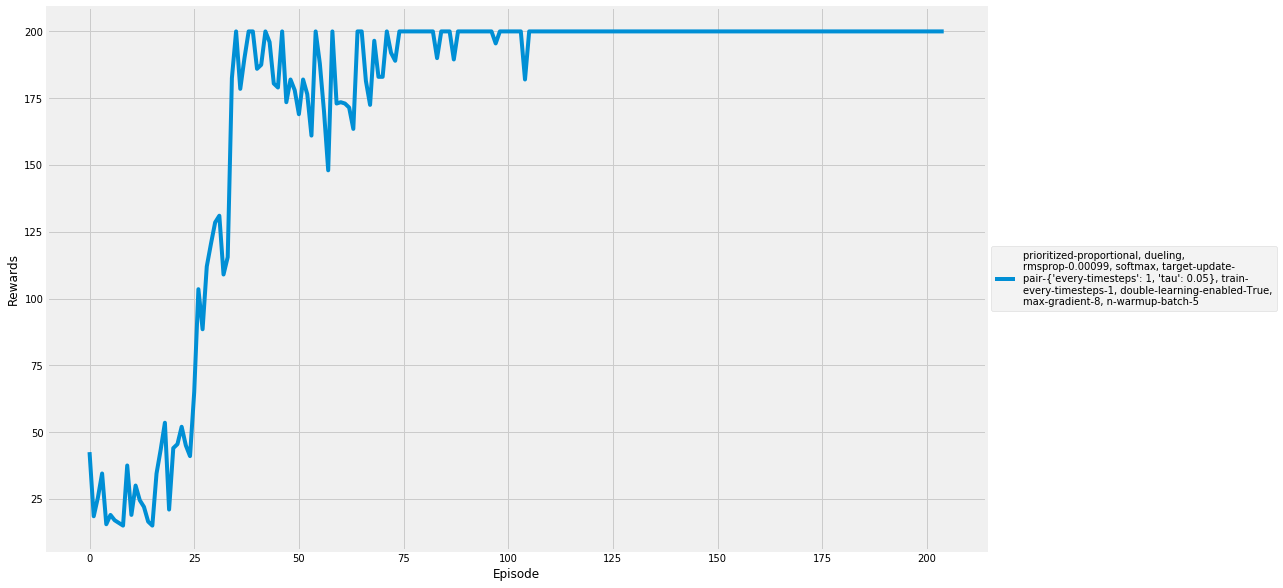

In [28]:
plot_results(training_results, log_scale=False)

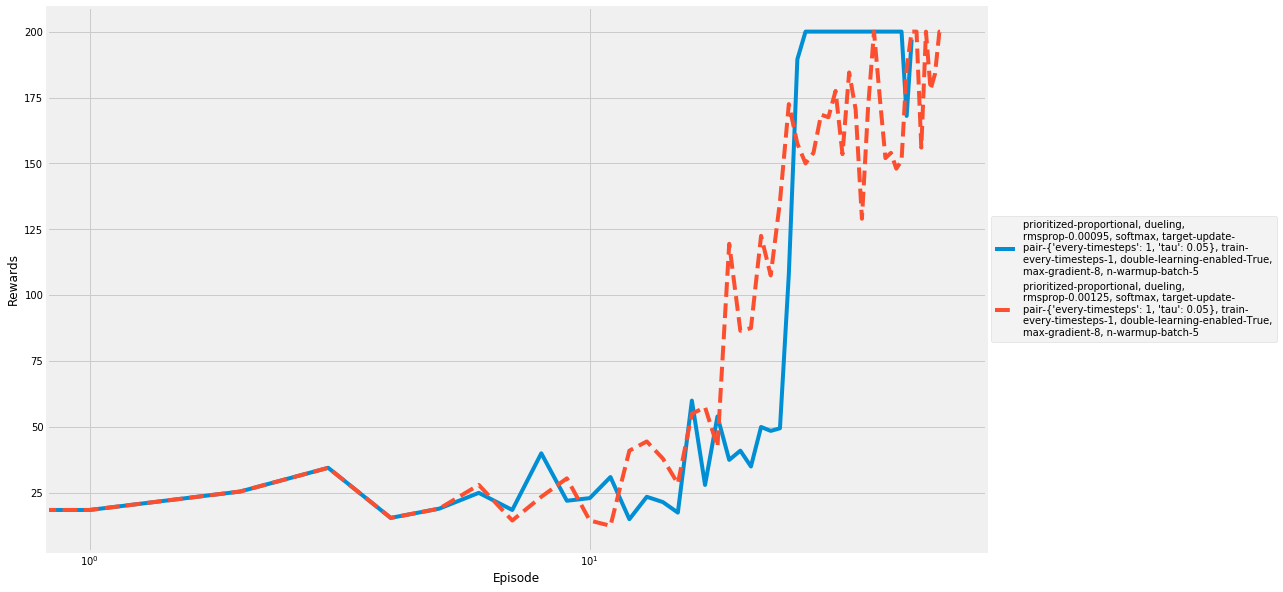

In [20]:
plot_results(training_results, log_scale=True)


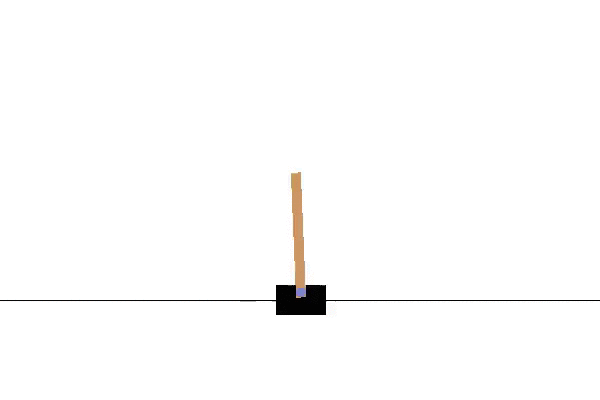
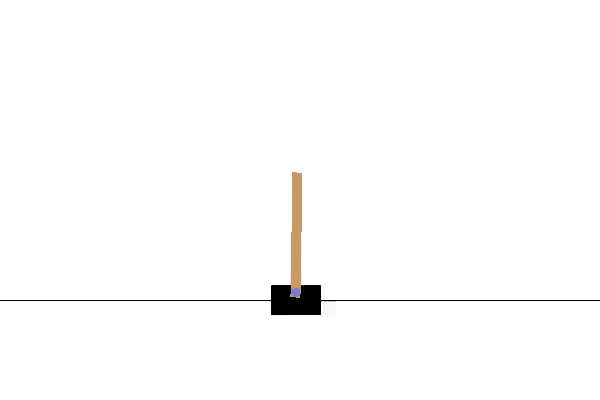
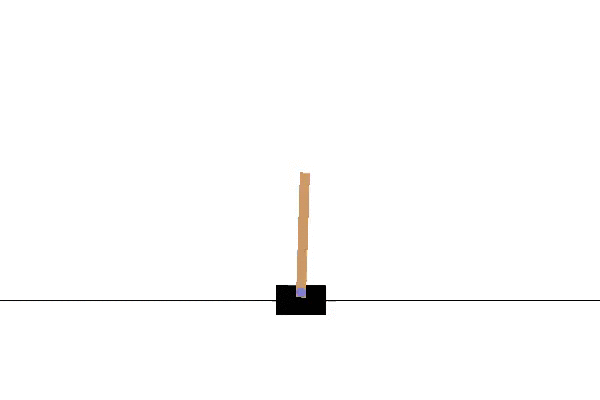
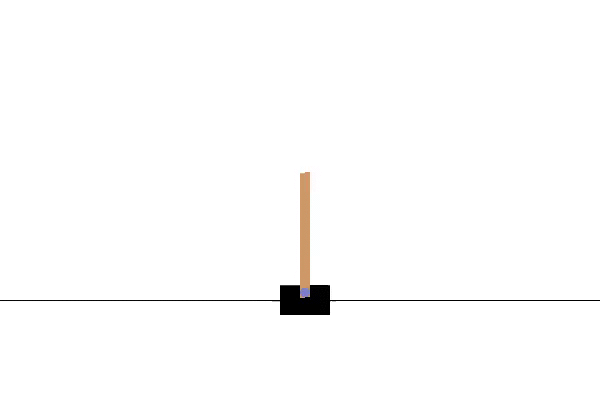

In [23]:
HTML(data=get_gif_html(env_videos=best_training_env.videos, title='Training evolution', max_n_videos=5))

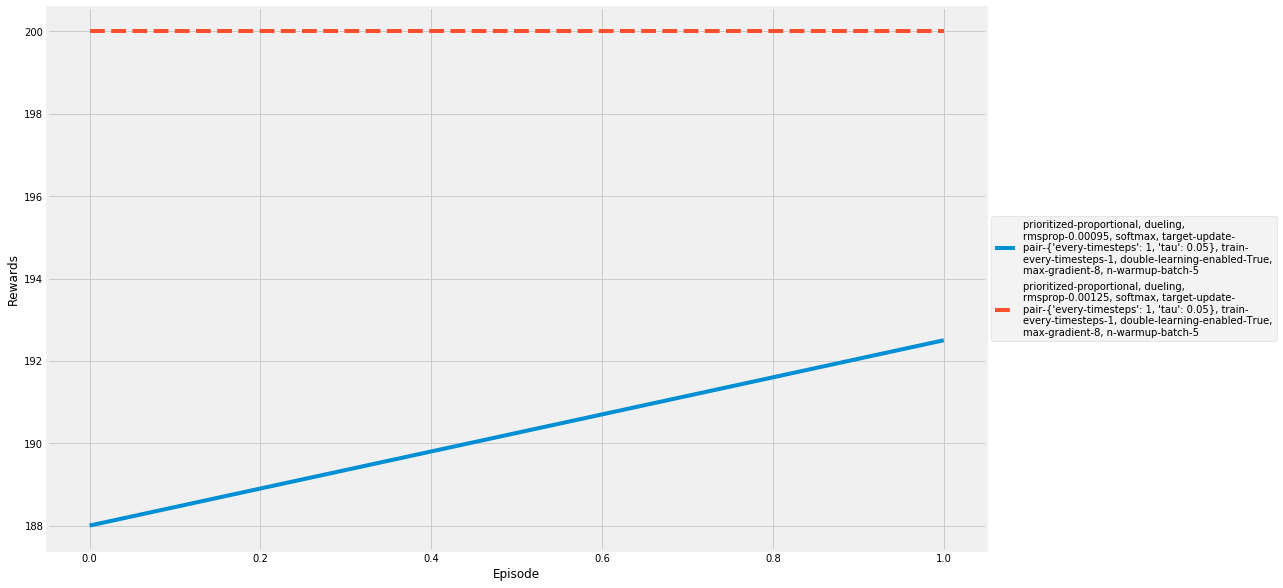

In [24]:
plot_results(evaluation_results, log_scale=False)

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))


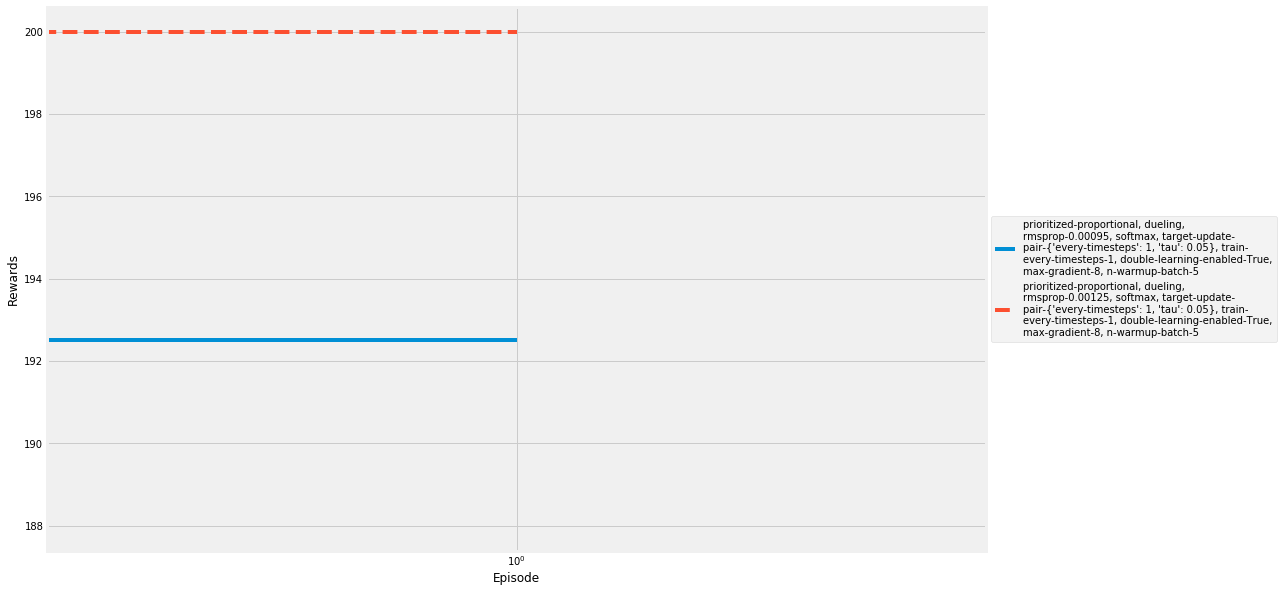

In [25]:
plot_results(evaluation_results, log_scale=True)


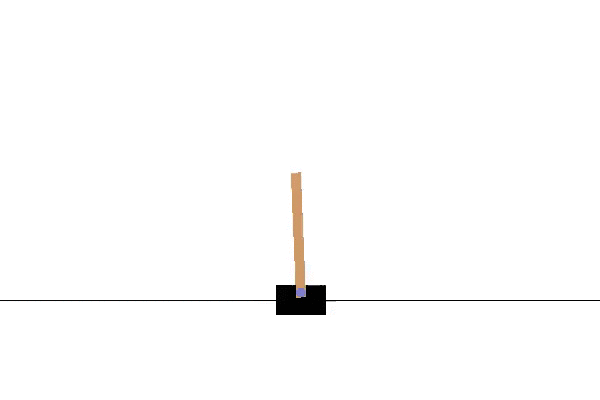
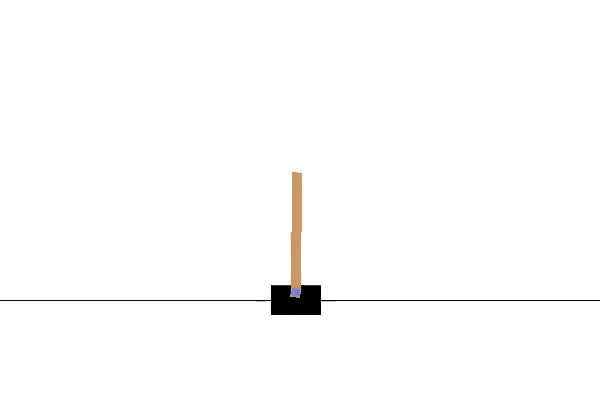

In [26]:
HTML(data=get_gif_html(env_videos=best_evaluation_env.videos, title='Evaluation results', max_n_videos=3))